# Clustering Abstract

In this excercise, we will use K-Means on Abstract records then we will see if each cluster corresponds mostly to a particular Directorate. This will tell us if directorate are truly distinct from each other or if there are overlaps between each other.

There are 7 Directorates in the NSF organization and a few offices. Offices were grouped together so that we will set K-Means to look for 8 clusters. The list of possible categories is then:
1. Directorate for Biological Sciences
2. Directorate for Computer & Information Science & Engineering
3. Directorate for Education & Human Resources
4. Directorate for Engineering
5. Directorate for Geosciences
6. Directorate for Mathematical & Physical Sciences
7. Directorate for Social, Behavioral & Economic Sciences



<img src="img/Directorate_categories.png" width="800">

## Directorate Classification based on Abstract
After runnning MiniBatch KMeans multiple times, It seems that Mathematical & Physical Sciences is the most common directorate for 3 clusters. It is somewhat understandable since Mathematic is at the based of every science.

Typical example:<br>
Cluster 1, directorate geosciences<br>
Cluster 2, directorate social behavioral economic sciences<br>
Cluster 3, directorate mathematical physical sciences<br>
Cluster 4, directorate biological sciences<br>
Cluster 5, directorate education human resources<br>
Cluster 6, directorate mathematical physical sciences<br>
Cluster 7, directorate mathematical physical sciences<br>

Top terms per cluster:<br>
Cluster 0: climate ocean ice water change sea model carbon sediment data<br>
Cluster 1: data research project model study social information new ha analysis<br>
Cluster 2: material research chemistry property high surface new metal electron energy<br>
Cluster 3: cell protein plant specie genetic dna molecular research study project<br>
Cluster 4: student science program research project teacher engineering course school college<br>
Cluster 5: conference workshop research meeting held support researcher science international student<br>
Cluster 6: problem theory algorithm network design research application project model methods<br>

If the NSF wants to reorganise their directorate it could look like this way:


<img src="img/Directorate_categories_reorg.png" width="800">

## Load data

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 14 02:02:58 2017

@author: herma
"""

# import custom vectorizer and associated function
from utils import utilsvectorizer

# don't use use stopwords from nltk
#from nltk.corpus import stopwords
#sw = stopwords.words('english')
## sklearn stopword list is more extensive, ENGLISH_STOP_WORDS is the same
## as stop_words='english' for CountVectorizer
from sklearn.feature_extraction import stop_words
# add list of first names from nltk, ATTENTION names has duplicates!!! use union()
# and each name starts with a CAPITAL LETTER
from nltk.corpus import names
firstname_corp = [na.lower() for na in names.words()]
sw = stop_words.ENGLISH_STOP_WORDS.union(firstname_corp)

#######-----------------------------------------------------------------#######
from utils import Abstract_transformation as abt
# get data set
df_corpus = abt.get_Abstract('Abstract_full_Startdate.csv')
#######-----------------------------------------------------------------#######
from utils import Directorate_transformation as dit
# get data set
df_direct = dit.get_Directorate('DB_1960_to_2017.csv')
#######-----------------------------------------------------------------#######


# MERGE
#######-----------------------------------------------------------------#######
import pandas as pd
# merge corpus and target on AwardID. AwardID is conserved
df = pd.merge(df_corpus, df_direct, how='inner', on=['AwardID'])
#######-----------------------------------------------------------------#######
# temporary downsizez of data
#df = df.iloc[:10000]

# LABEL
#######-----------------------------------------------------------------#######
target = df.Directorate_Name
# label those categories
from sklearn.preprocessing import LabelEncoder
Directorate_encoder = LabelEncoder()
Directorate_coded = Directorate_encoder.fit_transform(target)
target_names_list = Directorate_encoder.classes_
#######-----------------------------------------------------------------#######


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


## Vectorize text

In [2]:
## #############################################################################
# Do the actual clustering
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from sklearn.metrics import accuracy_score
from time import time
from scipy.stats import mode
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# need a vectorizer
vectorizer = utilsvectorizer.CustomVectorizer( min_df = 1,
                              max_df = 1.0,\
                              analyzer = 'word',\
                              stop_words = sw,\
                              strip_accents = 'unicode',\
                              token_pattern = r'(?u)\b[a-zA-Z][a-zA-Z]+\b',\
                        preprocessor = utilsvectorizer.remove_Tag_Http )
# proceed with Count vectorizer first
Abstract_features_array = vectorizer.fit_transform(df.Raw_Abstract)
# TFID vectorizer
# instantiate tfidf, normalize counts and lower weights of high frequencies
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(Abstract_features_array)
print(X.shape)

# number of label representing directorate
labels = df_direct.Directorate_Name.unique()
# number of expected cluster
true_k = df_direct.Directorate_Name.unique().shape[0]


(313975, 341518)


## Train model

In [9]:
# use Kmeans unsupervised learning
# verbose produces looging info
#km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
#                verbose=0, n_jobs = -1)
# init_size=1000 or 3*batch_size by default 
km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=100,
                             batch_size=10000, verbose=0)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

#from sklearn.externals import joblib
#joblib.dump(km, 'Kmeans_default_Model.pkl')
##km = joblib.load('Kmeans_default_Model.pkl') 

Clustering sparse data with MiniBatchKMeans(batch_size=10000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=7,
        n_init=100, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 125.541s



## Results and Metrics

How well does it match our Directorate?
Cluster 1, directorate geosciences
Cluster 2, directorate mathematical physical sciences
Cluster 3, directorate mathematical physical sciences
Cluster 4, directorate computer information science engineering
Cluster 5, directorate education human resources
Cluster 6, directorate mathematical physical sciences
Cluster 7, directorate biological sciences
Match score = 0.1603
[[15752  4564  2023     0 16737  3756     0]
 [  380 27064  2089     0   138  6882     0]
 [  518  3979 24236     0   346  3267     0]
 [ 3367 20915  3827     0  1166 29309     0]
 [  240  5471  1528     0 27470 13292     0]
 [ 1869  3511  3552     0   487 57982     0]
 [   67 20940   937     0  4091  2223     0]]
Top terms per cluster:
Cluster 0: specie climate change ocean water study ice plant data project
Cluster 1: theory problem equation model method geometry algorithm space mathematical research
Cluster 2: material research chemistry property surface study high structure n

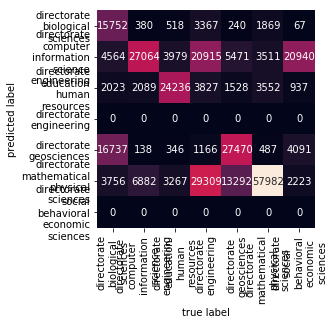

In [10]:
%matplotlib inline

# print("Homogeneity: %0.3f" % metrics.homogeneity_score(Directorate_coded, km.labels_))
# print("Completeness: %0.3f" % metrics.completeness_score(Directorate_coded, km.labels_))
# print("V-measure: %0.3f" % metrics.v_measure_score(Directorate_coded, km.labels_))
# print("Adjusted Rand-Index: %.3f"
#       % metrics.adjusted_rand_score(Directorate_coded, km.labels_))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, km.labels_, sample_size=1000))
#print()

print("How well does it match our Directorate?")
# does it match our Directorate?
pred_clusters = km.predict(X)
Pred_DirectName_coded = np.zeros_like(pred_clusters)
Clusters_names_coded = np.zeros((true_k,1), dtype =int)
for i in range(true_k):
    mask = (pred_clusters == i)
    Pred_DirectName_coded[mask] = mode(Directorate_coded[mask])[0]
    Clusters_names_coded[i] = mode(Directorate_coded[mask])[0]
# recover names of directorate
Clusters_names = Directorate_encoder.inverse_transform(Clusters_names_coded)
# print cluster number and most frequent directorate name
for i in range(true_k):
    print('Cluster {}, {}'.format(\
          i+1,*Clusters_names[i]))

# accuracy score
score = accuracy_score(Directorate_coded, pred_clusters)
print('Match score = {:.4f}'.format(score))
# confusion matrix
mat = metrics.confusion_matrix(Directorate_coded, Pred_DirectName_coded)
print(mat)
target_names_list_mod = [ '\n'.join(tn.split()) \
                         for tn in target_names_list]
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names_list_mod,
            yticklabels=target_names_list_mod)
plt.xlabel('true label')
plt.ylabel('predicted label');


print("Top terms per cluster:")
# clusters center should be an array of true_k * vocab
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
        print("Cluster %d:" % i, end='')
          # print the top 10 words for each cluster
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()